# TorchVision 0.3 Object Detection finetuning tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [3]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

UsageError: Cell magic `%%shell` not found.


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [0]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2019-05-23 17:42:56--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.4MB/s    in 5.1s    

2019-05-23 17:43:02 (9.98 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2019-05-23 17:43:02--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2019-05-23 17:43:02--
Total wall clock time: 6.3s
Downloaded: 1 files, 51M in 5.1s (9.98 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

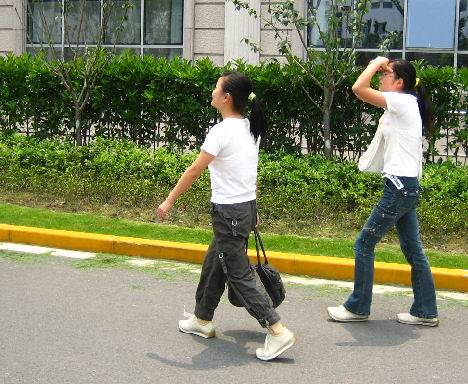

In [1]:
from PIL import Image
Image.open('data/PennFudanPed/PNGImages/FudanPed00012.png')

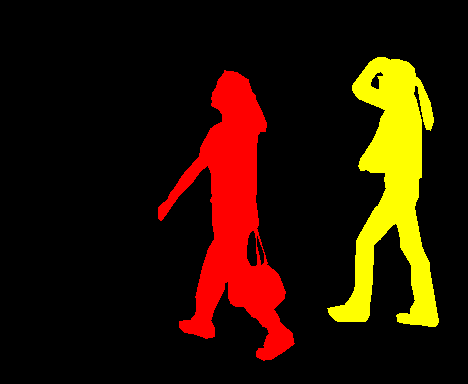

In [2]:
mask = Image.open('data/PennFudanPed/PedMasks/FudanPed00012_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [4]:
tt = np.array(Image.open('data/PennFudanPed/PedMasks/FudanPed00012_mask.png'))
tt[200] # 각 픽셀마다 1,2 등으로 인덱스를 지정

NameError: name 'np' is not defined

In [3]:
np.unique(tt)

NameError: name 'np' is not defined

In [43]:
np.unique(tt)[:, None, None]

array([[[0]],

       [[1]],

       [[2]]], dtype=uint8)

In [45]:
tt == np.unique(tt)[1:, None, None]

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [46]:
(tt == np.unique(tt)[1:, None, None])[0,200]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [50]:
np.where((tt == np.unique(tt)[1:, None, None])[0])

(array([ 70,  70,  71, ..., 359, 360, 360]),
 array([224, 225, 224, ..., 271, 263, 264]))

In [55]:
np.where((tt == np.unique(tt)[1:, None, None])[0])[0].shape

(14964,)

In [56]:
np.where((tt == np.unique(tt)[1:, None, None])[0])[1].shape

(14964,)

In [57]:
np.where((tt == np.unique(tt)[1:, None, None])[0])[0] == 70

array([ True,  True, False, ..., False, False, False])

In [58]:
(tt == np.unique(tt)[1:, None, None])[0,70] # where 절은 만족하는 픽셀을 축별 tuple로 전부 뽑아줌

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [28]:
list(sorted(os.listdir(os.path.join('data/PennFudanPed/', "PNGImages"))))

['FudanPed00001.png',
 'FudanPed00002.png',
 'FudanPed00003.png',
 'FudanPed00004.png',
 'FudanPed00005.png',
 'FudanPed00006.png',
 'FudanPed00007.png',
 'FudanPed00008.png',
 'FudanPed00009.png',
 'FudanPed00010.png',
 'FudanPed00011.png',
 'FudanPed00012.png',
 'FudanPed00013.png',
 'FudanPed00014.png',
 'FudanPed00015.png',
 'FudanPed00016.png',
 'FudanPed00017.png',
 'FudanPed00018.png',
 'FudanPed00019.png',
 'FudanPed00020.png',
 'FudanPed00021.png',
 'FudanPed00022.png',
 'FudanPed00023.png',
 'FudanPed00024.png',
 'FudanPed00025.png',
 'FudanPed00026.png',
 'FudanPed00027.png',
 'FudanPed00028.png',
 'FudanPed00029.png',
 'FudanPed00030.png',
 'FudanPed00031.png',
 'FudanPed00032.png',
 'FudanPed00033.png',
 'FudanPed00034.png',
 'FudanPed00035.png',
 'FudanPed00036.png',
 'FudanPed00037.png',
 'FudanPed00038.png',
 'FudanPed00039.png',
 'FudanPed00040.png',
 'FudanPed00041.png',
 'FudanPed00042.png',
 'FudanPed00043.png',
 'FudanPed00044.png',
 'FudanPed00045.png',
 'FudanPed

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages")))) # 이미지 이름을 리스트화
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask) # 인덱스를 집합화
        # first id is the background, so remove it
        obj_ids = obj_ids[1:] # 0은 제외

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None] # 바로 위 예제를 보면 이해됨

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i]) # 축별 픽셀 위치
            xmin = np.min(pos[1]) 
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) # 마스크를 둘러싼 박스 정보
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64) 
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [6]:
dataset = PennFudanDataset('data/PennFudanPed/')
dataset[3]

(<PIL.Image.Image image mode=RGB size=396x397 at 0x1CAF6FE0E88>,
 {'boxes': tensor([[167.,  59., 323., 337.],
          [  8.,  60.,  47., 179.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([3]),
  'area': tensor([43368.,  4641.]),
  'iscrowd': tensor([0, 0])})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

In [64]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 


In [66]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.


In [67]:
backbone = torchvision.models.mobilenet_v2(pretrained=True)

In [68]:
backbone

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

In [7]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features #feature와 classifier가 있음
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [8]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [72]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    for param in model.parameters():
        param.requires_grad= False
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [9]:
#%%shell

# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
error: pathspec 'v0.3.0' did not match any file(s) known to git.
cp: references/detection/utils.py: No such file or directory
cp: references/detection/transforms.py: No such file or directory
cp: references/detection/coco_eval.py: No such file or directory
cp: references/detection/engine.py: No such file or directory
cp: references/detection/coco_utils.py: No such file or directory




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [11]:
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

In [76]:
len(dataset)

170

In [12]:
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [79]:
len(dataset)

120

In [13]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [91]:
for data in model.named_parameters():
    print(data)

('backbone.body.conv1.weight', Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
     

('backbone.body.layer1.2.conv2.weight', Parameter containing:
tensor([[[[ 3.3096e-02, -2.2837e-03, -2.6060e-02],
          [-1.8888e-03, -1.4137e-02, -7.5973e-03],
          [-4.9556e-02,  2.8547e-02, -1.2019e-02]],

         [[ 2.0762e-02, -6.0752e-02,  1.7711e-02],
          [ 2.2331e-02, -5.3168e-02,  2.7273e-02],
          [-1.8588e-02,  7.2604e-03, -4.4545e-03]],

         [[ 1.1293e-02,  4.2911e-03,  2.0791e-02],
          [-2.3401e-03, -1.7693e-02,  1.8178e-02],
          [-5.9822e-03, -9.6152e-03,  8.1386e-03]],

         ...,

         [[ 1.3661e-02, -1.2209e-02, -4.6657e-03],
          [-3.2961e-03, -3.7944e-03, -2.1736e-02],
          [-2.4662e-02,  2.3986e-02, -1.5785e-02]],

         [[-4.2326e-02,  5.5694e-03,  1.0661e-02],
          [-4.7409e-02,  3.7776e-02,  2.1256e-02],
          [-9.4837e-03,  1.1733e-02, -6.1717e-03]],

         [[ 3.1075e-03, -7.9047e-03, -2.5325e-02],
          [ 8.5359e-03, -6.7326e-03, -1.2789e-02],
          [ 7.2580e-03, -1.6795e-02, -7.6375e-

('backbone.body.layer2.1.conv1.weight', Parameter containing:
tensor([[[[ 3.4016e-02]],

         [[-2.6136e-04]],

         [[-6.9195e-05]],

         ...,

         [[ 1.4385e-09]],

         [[-2.0822e-03]],

         [[ 6.0417e-02]]],


        [[[-1.1295e-02]],

         [[ 1.0638e-03]],

         [[-4.0810e-05]],

         ...,

         [[ 2.8247e-09]],

         [[ 1.2903e-02]],

         [[-2.0914e-02]]],


        [[[-3.2704e-02]],

         [[-5.0103e-05]],

         [[ 2.6280e-05]],

         ...,

         [[-3.4779e-09]],

         [[ 6.3080e-03]],

         [[-3.5199e-02]]],


        ...,


        [[[ 1.6850e-03]],

         [[ 2.8115e-04]],

         [[ 1.3702e-04]],

         ...,

         [[ 8.7213e-09]],

         [[-9.1110e-03]],

         [[-2.5388e-02]]],


        [[[-2.8025e-02]],

         [[-1.1740e-03]],

         [[-3.5154e-05]],

         ...,

         [[-8.7318e-09]],

         [[ 4.3544e-03]],

         [[ 1.8279e-02]]],


        [[[ 3.7152e-02]],

 

('backbone.body.layer2.3.conv2.weight', Parameter containing:
tensor([[[[ 0.0118,  0.0108, -0.0075],
          [-0.0221,  0.0119,  0.0131],
          [-0.0089,  0.0020, -0.0011]],

         [[ 0.0043,  0.0128,  0.0146],
          [ 0.0014,  0.0334,  0.0051],
          [ 0.0108,  0.0275, -0.0052]],

         [[ 0.0063,  0.0257,  0.0333],
          [ 0.0126, -0.0018, -0.0026],
          [ 0.0202,  0.0158, -0.0019]],

         ...,

         [[ 0.0103,  0.0059,  0.0050],
          [ 0.0166, -0.0023, -0.0064],
          [ 0.0161, -0.0142, -0.0209]],

         [[ 0.0190, -0.0142, -0.0169],
          [ 0.0032, -0.0155, -0.0104],
          [ 0.0056,  0.0004, -0.0117]],

         [[-0.0064, -0.0106,  0.0127],
          [-0.0238, -0.0280,  0.0036],
          [-0.0101,  0.0247,  0.0350]]],


        [[[-0.0193,  0.0168,  0.0053],
          [ 0.0135, -0.0253,  0.0237],
          [ 0.0363, -0.0121, -0.0238]],

         [[-0.0192, -0.0317,  0.0061],
          [ 0.0181, -0.0221,  0.0254],
          

('backbone.body.layer3.2.conv2.weight', Parameter containing:
tensor([[[[-6.1572e-03,  2.8042e-04,  1.3111e-03],
          [ 3.7885e-03,  3.9579e-03,  2.7219e-03],
          [-1.6604e-03, -6.2122e-03,  4.4026e-03]],

         [[-5.8898e-05,  2.4779e-03, -3.2570e-03],
          [ 1.6235e-02,  1.1391e-02,  1.0886e-02],
          [ 1.0335e-02,  4.1609e-03, -2.0628e-03]],

         [[ 4.2420e-03,  9.2680e-03,  3.0311e-03],
          [-6.3408e-03, -8.2191e-03, -8.8421e-03],
          [ 7.2362e-03,  1.1742e-02,  4.7039e-03]],

         ...,

         [[-9.9008e-03, -5.7840e-03, -9.3531e-03],
          [-5.4213e-03, -8.5433e-03,  4.0124e-04],
          [ 9.8704e-03,  1.9893e-02,  1.2366e-02]],

         [[-7.1762e-04,  4.3308e-03, -2.8966e-03],
          [ 3.6717e-03,  5.6796e-03, -2.8923e-03],
          [ 1.0130e-02,  2.7646e-03,  5.3012e-03]],

         [[ 5.4744e-02,  2.4267e-02, -1.4688e-02],
          [ 6.1614e-02,  1.2223e-02, -3.9580e-02],
          [ 4.7745e-02,  4.9898e-03, -4.3384e-

('backbone.body.layer3.4.conv2.weight', Parameter containing:
tensor([[[[ 9.7465e-03,  1.2276e-02, -1.5435e-03],
          [-3.6106e-04, -5.8326e-03, -1.9475e-03],
          [ 1.0206e-03,  4.0742e-03, -6.2749e-03]],

         [[-3.0098e-02, -1.9820e-02, -2.4830e-02],
          [-2.4306e-02, -1.0269e-02, -1.8074e-02],
          [-4.9107e-03,  2.3573e-02, -4.0129e-03]],

         [[-1.9092e-02, -4.3046e-03,  1.3982e-03],
          [-4.8490e-04,  8.6951e-04,  9.3732e-04],
          [-1.6034e-03, -6.9624e-03,  3.7044e-03]],

         ...,

         [[-1.9128e-04,  2.7911e-03, -5.1808e-03],
          [ 1.0732e-02,  1.2983e-03,  9.8515e-03],
          [-9.4783e-03, -1.0039e-03,  1.0761e-03]],

         [[ 1.1536e-02, -1.2198e-02,  1.0594e-03],
          [ 8.2166e-03, -2.1199e-02, -6.3262e-04],
          [ 1.5518e-03, -7.9098e-03, -1.4428e-02]],

         [[ 3.5170e-04, -1.0084e-02, -1.0898e-03],
          [ 9.5815e-03, -1.0816e-03,  6.3585e-04],
          [ 1.4482e-02,  5.5327e-04,  8.3687e-

('backbone.body.layer4.0.downsample.0.weight', Parameter containing:
tensor([[[[-0.0052]],

         [[ 0.0043]],

         [[ 0.0055]],

         ...,

         [[ 0.0035]],

         [[-0.0055]],

         [[-0.0048]]],


        [[[-0.0082]],

         [[ 0.0049]],

         [[-0.0076]],

         ...,

         [[-0.0019]],

         [[-0.0057]],

         [[-0.0045]]],


        [[[-0.0122]],

         [[ 0.0052]],

         [[ 0.0075]],

         ...,

         [[-0.0119]],

         [[-0.0048]],

         [[-0.0061]]],


        ...,


        [[[-0.0051]],

         [[ 0.0119]],

         [[ 0.0016]],

         ...,

         [[-0.0035]],

         [[-0.0029]],

         [[ 0.0004]]],


        [[[-0.0027]],

         [[ 0.0041]],

         [[ 0.0007]],

         ...,

         [[-0.0044]],

         [[ 0.0022]],

         [[ 0.0019]]],


        [[[-0.0031]],

         [[ 0.0033]],

         [[-0.0078]],

         ...,

         [[ 0.0066]],

         [[ 0.0045]],

         [[

('backbone.fpn.inner_blocks.2.weight', Parameter containing:
tensor([[[[ 0.0138]],

         [[-0.0040]],

         [[ 0.0069]],

         ...,

         [[ 0.0034]],

         [[-0.0065]],

         [[-0.0079]]],


        [[[ 0.0151]],

         [[ 0.0047]],

         [[ 0.0292]],

         ...,

         [[ 0.0040]],

         [[-0.0020]],

         [[-0.0118]]],


        [[[-0.0037]],

         [[-0.0053]],

         [[-0.0065]],

         ...,

         [[ 0.0009]],

         [[ 0.0049]],

         [[-0.0107]]],


        ...,


        [[[-0.0021]],

         [[-0.0134]],

         [[ 0.0201]],

         ...,

         [[-0.0152]],

         [[-0.0008]],

         [[-0.0010]]],


        [[[-0.0067]],

         [[ 0.0130]],

         [[ 0.0087]],

         ...,

         [[ 0.0058]],

         [[-0.0009]],

         [[-0.0049]]],


        [[[ 0.0041]],

         [[-0.0214]],

         [[ 0.0048]],

         ...,

         [[-0.0053]],

         [[ 0.0044]],

         [[ 0.0063]

('backbone.fpn.layer_blocks.3.weight', Parameter containing:
tensor([[[[-9.0204e-03,  2.6588e-03,  6.1796e-03],
          [-4.8904e-04,  1.1330e-02,  1.2610e-02],
          [ 2.1502e-03,  9.5200e-03,  2.8736e-03]],

         [[ 9.4543e-04, -2.2302e-03, -1.6328e-03],
          [ 2.5195e-03,  2.0326e-03, -1.2144e-04],
          [ 5.9148e-03,  5.3774e-03,  9.5138e-03]],

         [[ 1.3975e-04, -1.6760e-03, -1.0433e-02],
          [ 1.9478e-03, -5.1429e-03, -7.3749e-03],
          [-9.8119e-03, -1.4823e-02, -1.4262e-02]],

         ...,

         [[-6.1041e-03, -4.5137e-03, -8.1716e-03],
          [-3.1512e-04, -1.8175e-03, -2.1855e-03],
          [-4.9193e-03, -6.7585e-03, -1.5040e-03]],

         [[-3.2679e-04,  4.5596e-03, -2.6590e-03],
          [ 2.6093e-03,  7.8566e-03,  2.0861e-03],
          [ 4.9653e-04,  5.0408e-03, -2.1470e-03]],

         [[-2.4951e-03, -9.3566e-03, -1.5275e-03],
          [-6.1128e-03, -1.2243e-02, -8.9094e-03],
          [-1.9581e-04, -5.7005e-03, -2.6271e-0

('roi_heads.box_predictor.bbox_pred.weight', Parameter containing:
tensor([[-0.0028,  0.0107,  0.0097,  ...,  0.0098,  0.0189, -0.0155],
        [-0.0198,  0.0080, -0.0062,  ...,  0.0022,  0.0107, -0.0249],
        [-0.0027, -0.0112,  0.0014,  ...,  0.0241,  0.0133, -0.0168],
        ...,
        [-0.0256, -0.0134,  0.0086,  ..., -0.0171,  0.0114, -0.0099],
        [ 0.0312,  0.0147,  0.0021,  ..., -0.0047,  0.0238, -0.0130],
        [ 0.0088,  0.0025,  0.0294,  ..., -0.0293, -0.0123,  0.0055]],
       requires_grad=True))
('roi_heads.box_predictor.bbox_pred.bias', Parameter containing:
tensor([ 0.0184,  0.0082,  0.0018,  0.0076, -0.0243,  0.0273, -0.0071,  0.0207],
       requires_grad=True))
('roi_heads.mask_head.mask_fcn1.weight', Parameter containing:
tensor([[[[ 1.8125e-04,  1.6358e-02,  1.2418e-02],
          [ 1.4792e-02,  3.0331e-02,  5.3690e-03],
          [ 8.7363e-03,  1.9324e-02,  1.5242e-02]],

         [[-8.5839e-04, -1.6353e-03, -1.3098e-03],
          [-5.4876e-03, -7.1

('roi_heads.mask_head.mask_fcn3.weight', Parameter containing:
tensor([[[[ 5.6343e-03,  1.2890e-03, -5.9221e-03],
          [ 5.1078e-03,  2.0735e-03, -2.9849e-03],
          [ 1.7197e-03,  3.6209e-03, -1.7226e-03]],

         [[-1.2657e-02, -1.2937e-02, -2.3214e-03],
          [-3.1332e-03, -1.6210e-02,  3.0642e-03],
          [-7.2516e-04, -3.1874e-03, -3.5359e-03]],

         [[ 4.3377e-03, -4.1273e-03, -3.5954e-03],
          [ 7.4382e-03, -9.5561e-03, -7.3385e-03],
          [-4.4149e-04, -1.4973e-02, -1.0545e-02]],

         ...,

         [[ 2.6903e-03, -6.5290e-04,  1.6757e-03],
          [ 4.3204e-03,  1.0564e-02, -4.2075e-03],
          [ 1.4896e-03,  8.0602e-03,  4.8506e-03]],

         [[ 4.5064e-03,  7.7961e-04,  3.8593e-03],
          [ 8.2374e-03, -8.2957e-04, -1.4990e-03],
          [ 8.2073e-03,  3.9347e-03, -5.6447e-03]],

         [[-5.0815e-03, -5.5781e-03, -5.4814e-03],
          [ 7.7454e-03,  6.3424e-03, -3.9536e-03],
          [ 1.1761e-02,  1.6533e-04,  3.0404e

('roi_heads.mask_head.mask_fcn4.bias', Parameter containing:
tensor([ 1.1476e-01,  2.4630e-02,  8.6052e-03, -9.7461e-04,  1.5652e-03,
         5.7002e-04,  3.2396e-03,  6.5185e-02,  8.3757e-04,  1.2179e-02,
         6.1299e-04,  9.5510e-03,  5.5391e-02,  1.1054e-02, -5.3728e-03,
         1.3586e-02,  7.9053e-03,  6.4050e-02,  3.0769e-02,  1.8987e-02,
         4.5772e-02,  1.6612e-02,  1.0092e-02,  8.4218e-03,  5.3652e-03,
         1.1479e-04,  6.1380e-03,  4.0351e-02,  7.6009e-03, -9.5841e-04,
         6.2205e-03,  2.9132e-03,  3.4086e-02,  1.4738e-02,  1.2077e-02,
         4.9267e-02,  3.8291e-05,  4.5285e-04, -2.0270e-03,  1.0456e-02,
         3.1006e-02,  2.0793e-03,  3.4376e-03, -3.7730e-04,  3.9111e-02,
         1.7942e-02,  7.9474e-03,  5.0788e-02, -3.2651e-03,  3.5066e-03,
         8.4792e-02,  7.3593e-03,  5.2434e-02,  2.6552e-03,  1.6342e-02,
        -7.5850e-03,  2.4340e-03,  4.4930e-02, -6.6599e-03,  1.9405e-03,
         2.6943e-03,  1.9253e-02,  1.0132e-02, -6.5781e-04,  2.

('roi_heads.mask_predictor.mask_fcn_logits.weight', Parameter containing:
tensor([[[[ 1.3153e+00]],

         [[ 2.2853e-02]],

         [[ 1.2012e+00]],

         [[-1.9431e-01]],

         [[-5.4254e-01]],

         [[-2.6336e+00]],

         [[-5.7221e-01]],

         [[ 1.4973e-02]],

         [[-8.1723e-01]],

         [[ 4.8832e-01]],

         [[ 2.9572e-02]],

         [[-4.8911e-01]],

         [[-1.2988e+00]],

         [[-1.6595e+00]],

         [[ 4.2255e-01]],

         [[-1.4651e-01]],

         [[ 1.0093e+00]],

         [[ 1.1828e-01]],

         [[-5.2706e-01]],

         [[ 2.1707e+00]],

         [[-4.7746e-01]],

         [[ 7.4614e-02]],

         [[-2.7005e-01]],

         [[ 7.6715e-01]],

         [[-9.0442e-02]],

         [[-7.1176e-01]],

         [[ 5.0078e-01]],

         [[-2.0992e-02]],

         [[-5.0106e-01]],

         [[-1.2185e+00]],

         [[ 4.1055e-01]],

         [[ 1.1332e+00]],

         [[ 1.1797e+00]],

         [[-1.6113e-01]],

        

In [16]:
# let's train it for 10 epochs
num_epochs = 7

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:26  lr: 0.000090  loss: 0.1812 (0.1812)  loss_classifier: 0.0211 (0.0211)  loss_box_reg: 0.0136 (0.0136)  loss_mask: 0.1230 (0.1230)  loss_objectness: 0.0200 (0.0200)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.4341  data: 0.0320  max mem: 1379
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 0.1961 (0.2198)  loss_classifier: 0.0249 (0.0296)  loss_box_reg: 0.0138 (0.0169)  loss_mask: 0.1275 (0.1449)  loss_objectness: 0.0198 (0.0222)  loss_rpn_box_reg: 0.0043 (0.0063)  time: 0.4094  data: 0.0299  max mem: 1379
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 0.2578 (0.2547)  loss_classifier: 0.0317 (0.0378)  loss_box_reg: 0.0191 (0.0243)  loss_mask: 0.1580 (0.1563)  loss_objectness: 0.0198 (0.0251)  loss_rpn_box_reg: 0.0095 (0.0111)  time: 0.4458  data: 0.0371  max mem: 1379
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.002629  loss: 0.2450 (0.2444)  loss_classifier: 0.0317 (0.0364)  loss_box_reg: 0.0189 (0.0223)  loss_mask: 0.1460 (0.1494)  loss_ob

 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
Epoch: [2]  [ 0/60]  eta: 0:00:31  lr: 0.005000  loss: 0.2471 (0.2471)  loss_classifier: 0.0308 (0.0308)  loss_box_reg: 0.0277 (0.0277)  loss_mask: 0.1541 (0.1541)  loss_objectness: 0.0251 (0.0251) 

KeyboardInterrupt: 

Now that training has finished, let's have a look at what it actually predicts in a test image

In [21]:
# pick one image from the test set
img, _ = dataset_test[20]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [22]:
prediction

[{'boxes': tensor([[110.8673, 167.7466, 208.1726, 446.8033],
          [392.2196, 163.4339, 512.3799, 457.6808],
          [  0.0000, 136.7361,  71.3022, 460.6162],
          [299.8469, 198.4967, 375.7413, 318.4897],
          [423.9013, 178.6778, 499.0473, 392.6497],
          [292.2219, 163.4689, 502.8612, 444.8993]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9974, 0.9974, 0.9849, 0.9229, 0.0732, 0.0675], device='cuda:0'),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
  
  
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
      

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

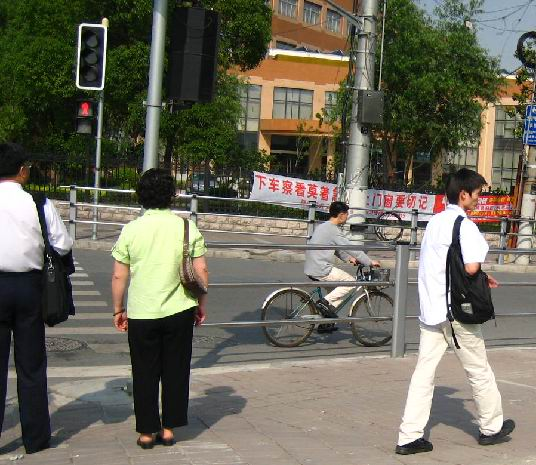

In [23]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

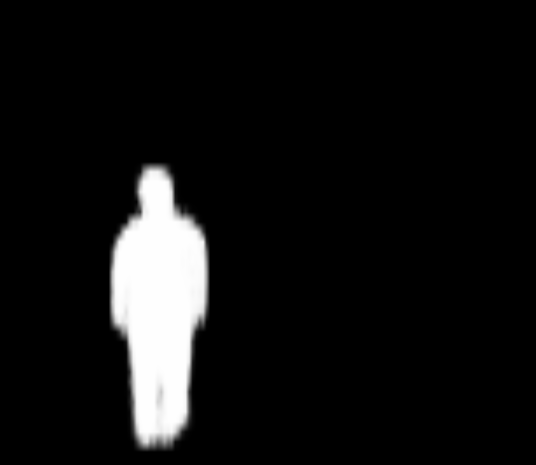

In [31]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

